- **Hakim Ziani**
- **Nassim Ettorche**

##Installation des bibliothèques :

In [2]:
!pip install node2vec
!pip install scikit-network
!pip install umap-learn hdbscan
#!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch

##Chargement des bibliothèques :

In [1]:
import dask.dataframe as dd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from transformers import BertModel, BertTokenizer
import torch
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from sknetwork.visualization import svg_graph
from IPython.display import SVG
from sklearn.cluster import SpectralClustering
from gensim import corpora, models
#import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis
from sklearn.manifold import TSNE
from gensim import matutils, models, corpora
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
import umap
import hdbscan
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import torch
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import node2vec

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
documents_path = '/content/gdrive/My Drive/data_MALIA/corpus_2015.csv'
citations_path = '/content/gdrive/My Drive/data_MALIA/cited_2015.csv'


Mounted at /content/gdrive


##Fonction 1 : Acquisition des données:

In [4]:
# Lecture des deux Donées
documents= pd.read_csv(documents_path,sep="\t",header=None)
citations= pd.read_csv(citations_path,sep="\t",header=None)

In [5]:
documents.rename({0:'ID',1:'title',2:'abstract',3:'venue'},axis=1,inplace=True)
documents['texte']= documents["abstract"] + documents["title"]

In [6]:
documents.venue.value_counts()

international conference on communications               2056
Sensors                                                  1412
advances in computing and communications                 1320
international geoscience and remote sensing symposium    1291
conference on decision and control                       1246
                                                         ... 
privacy in statistical databases                            1
Journal of Statistical Planning and Inference               1
Serials Review                                              1
Technical Services Quarterly                                1
Human-centric Computing and Information Sciences            1
Name: venue, Length: 2509, dtype: int64

In [7]:
#On conserve une copie non nettoyée pour faire de la recherche de pronoms plus tard dans le notebook
df_document = documents.copy()


# On supprime les lignes sans abstract ni titre si ils existent
print('Avant',df_document.texte.isna().sum())

df_document.texte = df_document.texte.dropna()
print('Apres',df_document.texte.isna().sum())


Avant 0
Apres 0


In [8]:
print('Documents shape',df_document.shape)
print('Citations shape',citations.shape)

Documents shape (188143, 5)
Citations shape (2232678, 2)


## Pre-traitement des données textuelles:

**Skip si le fichier pre processed existe deja**

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
ddf_document = dd.from_pandas(df_document, npartitions=8)

# # Récupérer la liste des stopwords en anglais
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
     word_tokens = word_tokenize(text)
     filtered_text = ' '.join([word for word in word_tokens if word not in stop_words])
     return filtered_text

ddf_document['texte'] = ddf_document['texte'].map_partitions(lambda df: df.apply(lambda x: remove_stopwords(x)))

#df_document_new = ddf_document.compute()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def preprocess_text(text):

     text = str(text).lower()
     text = text.replace("\n", "")
     # Supprimer les caractères spéciaux
     text = text.replace("\$x00","")
     text = text.replace("nan", " ")
     # Supprimer les caractères non alphabétiques
     text = "".join([x if (x.isalpha()) else " " for x in text])
     text = " ".join(text.split())
     return text

df_document['texte'] = df_document['texte'].apply(preprocess_text)

#df_document_new['texte'] = df_document_new['texte'].apply(preprocess_text)


In [ ]:
# path = '/content/gdrive/My Drive/data_MALIA/document_preprocessed.csv'
# df_document_new.to_csv(path,index=False)

**Uploader directement le fichier preprocessed pour le futur**

In [ ]:
df_document = pd.read_csv('/content/gdrive/My Drive/data_MALIA/document_preprocessed.csv')

# Statistiques utiles

On cherche les mots les plus fréquents dans le corpus :

In [ ]:
vectorizer = CountVectorizer(min_df=3,max_df=0.3)
X = vectorizer.fit_transform(df["texte"])
F=vectorizer.get_feature_names_out()

def top_feats(row, features, top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids if row[i]>0]
    df = pd.DataFrame(top_feats)
    if len(top_feats) > 0:
        df.columns = ['feature', 'score']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_feats(row, features, top_n)

D = X.toarray()

n_docs, n_terms = D.shape

tf_sum = np.sum(D, axis=0)
freq = top_feats(tf_sum, F)


<Axes: title={'center': 'Mots les plus fréquents'}, xlabel='mot'>

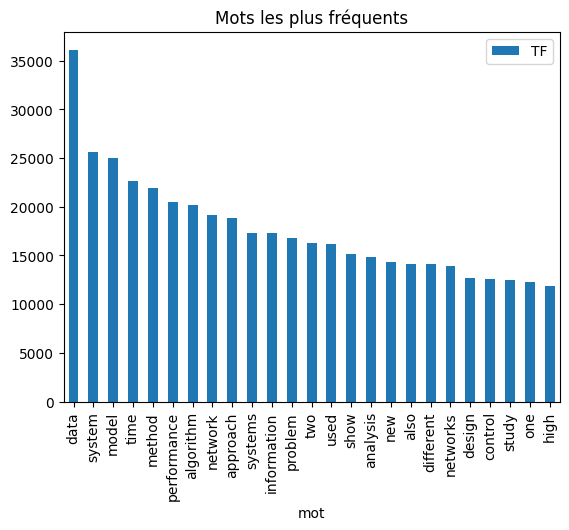

In [ ]:
top_f = freq.feature
top_v = freq.score
df2 = pd.DataFrame({'mot':top_f, 'TF':top_v})
df2.plot.bar(x='mot', y='TF', rot=90, title ="Mots les plus fréquents")


###Représentation vetorielle du Texte :

In [ ]:
text_vector_dict = {text: vec for text, vec in zip(df['texte'][:4], X[:4])}

for text, vec in text_vector_dict.items():
    print(f"Texte original : {text}\nReprésentation vectorielle : {vec}\n")

Texte original : the paper describes user behavior result introducing monetization freemium educational online platform monetization resulted alternative system growth mechanisms causing viral increase number users given different options users choose advantageous simple ones system metrics terms k factor utilized indicator system user base growth the weekly k factor almost doubled result monetization introduction monetization viral growth competing complementary mechanisms system growth monetization motivator freemium educational platform growth
Représentation vectorielle :   (0, 6688)	1
  (0, 28407)	2
  (0, 2310)	1
  (0, 22576)	2
  (0, 13650)	1
  (0, 16700)	5
  (0, 10450)	2
  (0, 8028)	2
  (0, 18288)	1
  (0, 19846)	2
  (0, 22579)	1
  (0, 845)	1
  (0, 26203)	4
  (0, 11334)	5
  (0, 15902)	2
  (0, 3569)	1
  (0, 28823)	2
  (0, 12867)	1
  (0, 17953)	1
  (0, 28410)	2
  (0, 10997)	1
  (0, 6952)	1
  (0, 18451)	1
  (0, 3946)	1
  (0, 453)	1
  (0, 24218)	1
  (0, 18282)	1
  (0, 16140)	1
  (0, 26

##Latent Dirichlet Allocation, LDA:

D'apres la colonne venue nous remarquons que les documents sont classifiées selon 10 majeurs classes c'est la raison por laquelles nous utilisons une lda avec num_topics = 10.

In [ ]:

# Conversion en format compatible avec Gensim
corpus_gensim = matutils.Sparse2Corpus(X, documents_columns=False)
word_id_map = dict((id, word) for word, id in vectorizer.vocabulary_.items())
dictionary = corpora.Dictionary()
dictionary.id2token = word_id_map
dictionary.token2id = vectorizer.vocabulary_

In [ ]:
lda_model = models.LdaModel(corpus=corpus_gensim, id2word=dictionary, num_topics=10, passes=15)

# Affichage des sujets
topics = lda_model.print_topics(num_words=20)
for topic in topics:
    print(topic)

(0, '0.018*"power" + 0.017*"channel" + 0.012*"performance" + 0.010*"scheme" + 0.009*"rate" + 0.009*"frequency" + 0.009*"signal" + 0.008*"interference" + 0.007*"system" + 0.007*"low" + 0.007*"noise" + 0.006*"spectrum" + 0.006*"design" + 0.006*"channels" + 0.006*"multiple" + 0.006*"transmission" + 0.006*"coding" + 0.005*"capacity" + 0.005*"high" + 0.005*"systems"')
(1, '0.009*"data" + 0.009*"analysis" + 0.006*"temporal" + 0.006*"brain" + 0.006*"activity" + 0.006*"network" + 0.006*"patterns" + 0.005*"patients" + 0.005*"event" + 0.005*"model" + 0.005*"neural" + 0.005*"events" + 0.005*"clinical" + 0.005*"medical" + 0.005*"time" + 0.005*"study" + 0.005*"protein" + 0.005*"patient" + 0.005*"networks" + 0.005*"disease"')
(2, '0.013*"data" + 0.012*"method" + 0.011*"image" + 0.010*"learning" + 0.008*"classification" + 0.008*"features" + 0.008*"approach" + 0.007*"methods" + 0.007*"detection" + 0.006*"model" + 0.006*"performance" + 0.006*"algorithm" + 0.006*"images" + 0.006*"feature" + 0.005*"recog

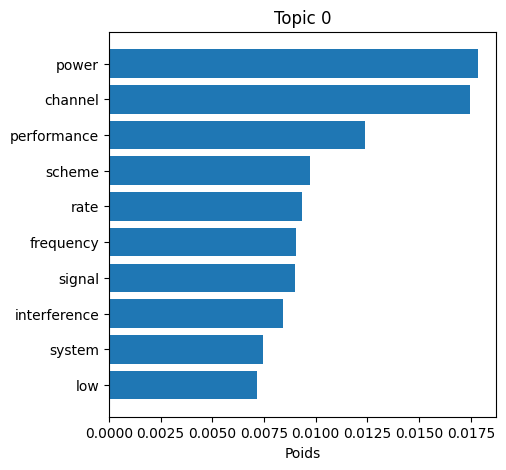

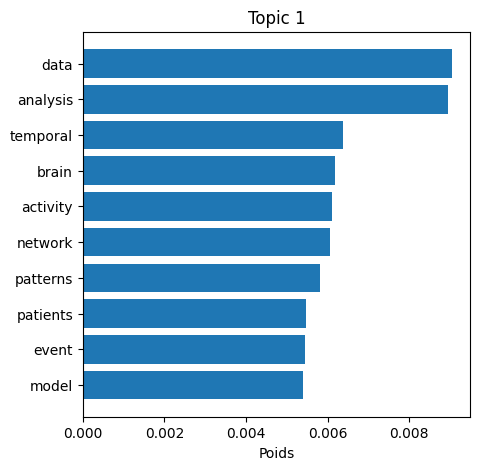

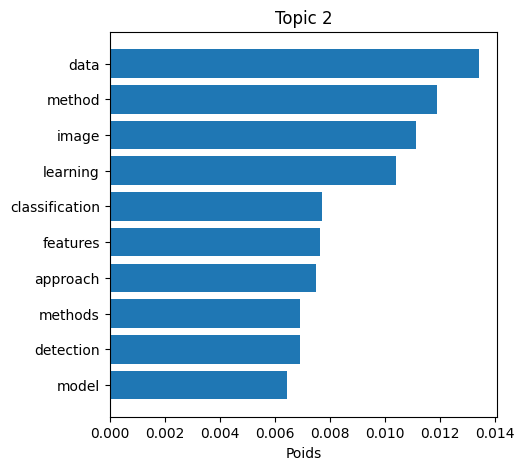

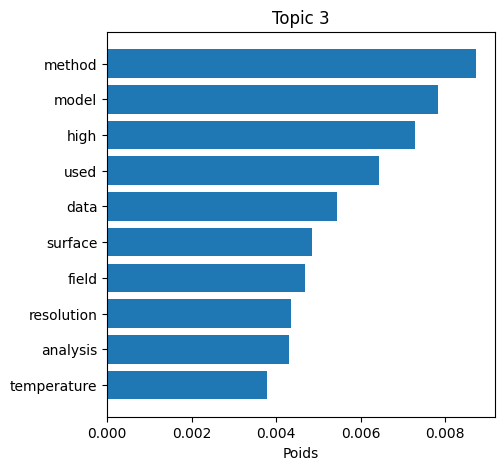

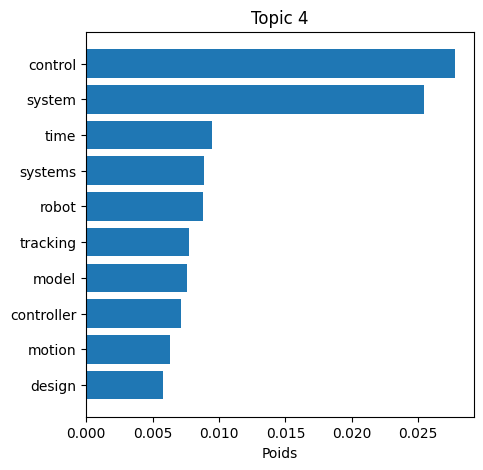

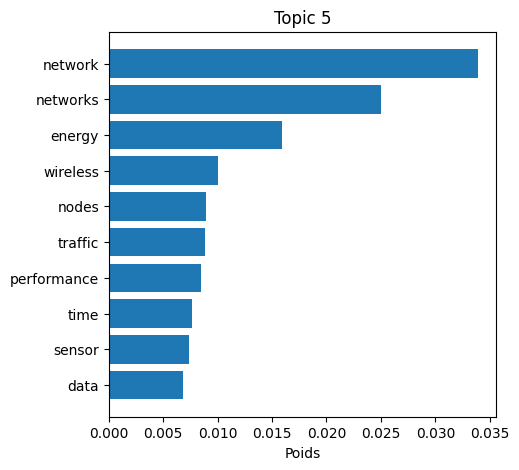

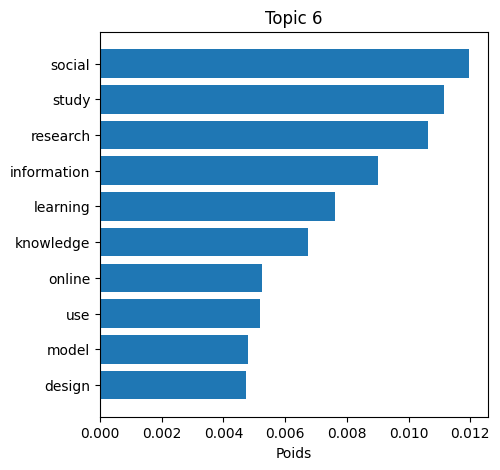

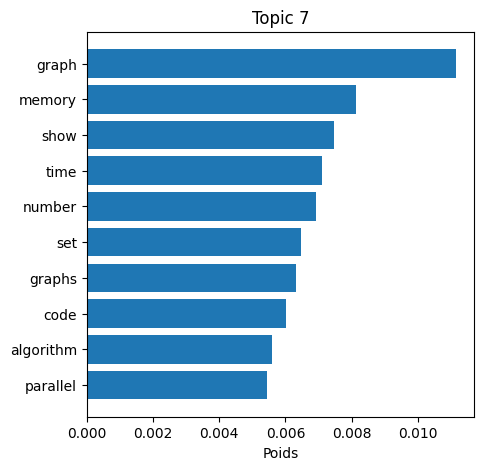

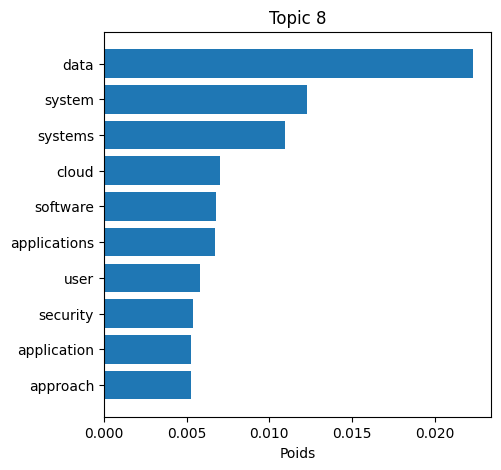

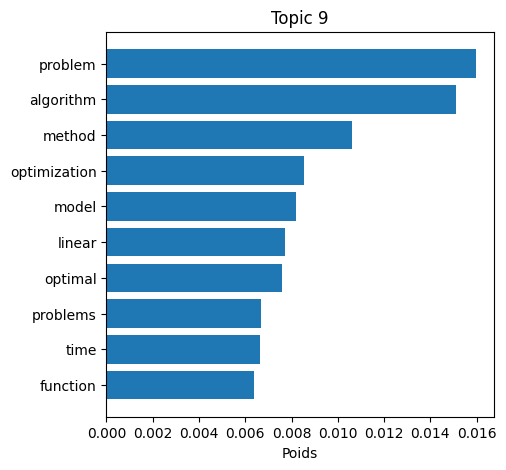

In [ ]:
n_top_words = 10

for topic_id, topic in lda_model.show_topics(num_topics=lda_model.num_topics, formatted=False, num_words=n_top_words):
    top_features = [word for word, weight in topic]
    weights = [weight for word, weight in topic]

    plt.figure(figsize=(5,5))
    plt.barh(range(n_top_words), weights, align='center')
    plt.yticks(range(n_top_words), top_features)
    plt.xlabel("Poids")
    plt.title(f"Topic {topic_id}")
    plt.gca().invert_yaxis()
    plt.show()


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.080s...
[t-SNE] Computed neighbors for 50000 samples in 10.395s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

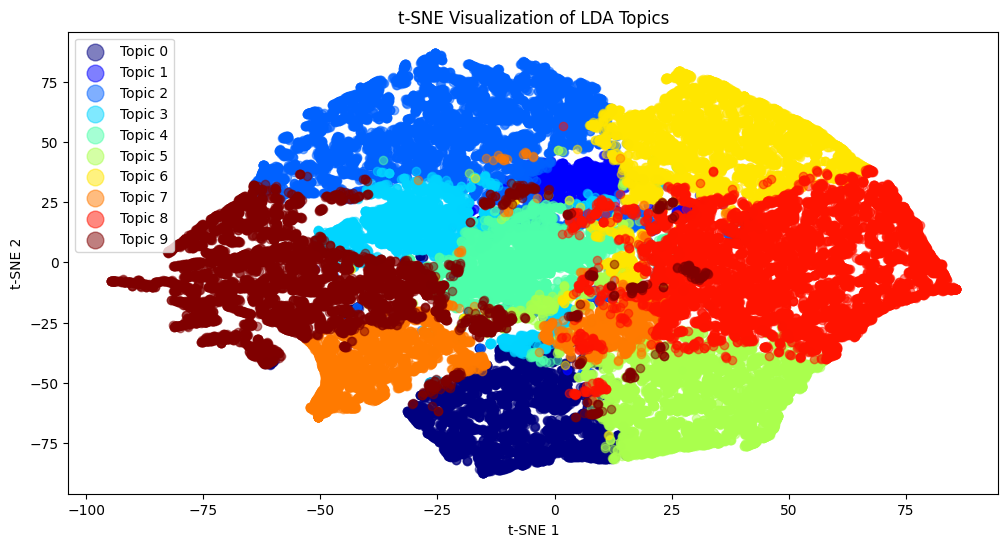

In [ ]:
topic_distributions = lda_model.get_document_topics(corpus_gensim, minimum_probability=0)

doc_topics = np.array([[prob for _, prob in doc] for doc in topic_distributions])

dominant_topic = np.argmax(doc_topics, axis=1)

# t-SNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(doc_topics)

max_dom_topic = max(dominant_topic)
colors = [plt.cm.jet(float(i)/max_dom_topic) for i in range(max_dom_topic+1)]

plt.figure(figsize=(12, 6))

for i, color in enumerate(colors):
    indices = dominant_topic == i
    plt.scatter(tsne_lda[indices, 0], tsne_lda[indices, 1], c=[color], label=f"Topic {i}", alpha=0.5)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization of LDA Topics')
plt.legend(markerscale=2)
plt.show()

#Création graphe  :

In [29]:
citations.rename({0:'target',1:'source'},axis=1,inplace=True)


In [10]:
df=resample(df_document, n_samples=50000, random_state=42, replace=False)


In [27]:
df = df.dropna(subset=['venue'])

IDS = set(df['ID'])

Associer a chaque document dans le dataFrame citations son libelle:

In [30]:
cit = citations[citations['target'].isin(IDS) & citations['source'].isin(IDS)]
id_label = pd.Series(df.venue.values, index=df.ID).to_dict()

cit['Label_target'] = cit['target'].map(id_label)
cit['Label_source'] = cit['source'].map(id_label)



<ipython-input-30-37836205d9e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cit['Label_target'] = cit['target'].map(id_label)
<ipython-input-30-37836205d9e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cit['Label_source'] = cit['source'].map(id_label)


##Visualisation d'un sous ensemble de graphe afin de voir chaque libel asssocié a un noeud:

In [31]:

row = cit[cit['Label_target'] == cit['Label_source']]

row

target  \
3242     d6452249-c660-496e-ae85-2675aeb071aa   
6984     13a77219-d07c-4c9f-b2d9-86ffb8082c82   
7398     1887f518-554b-45d5-9998-e11b1a261326   
8217     2165b350-7653-49b6-b0cb-d0fb07e15388   
12705    562c79e6-d1a7-4657-a1e0-7a5e150c5230   
...                                       ...   
2175706  0c9119c3-d490-4e86-bb25-2d23a005dd9d   
2176493  14d5e1ca-60d6-47cb-ba7c-1dbbf7c2b34d   
2181958  475fc0f6-6464-4c33-a4e5-aa62a9918a1b   
2186429  7346ee74-1b7a-4452-87c5-5c97cf41e90d   
2226406  4dca5920-e7ec-4417-9791-f254eccc49a5   

                                       source  \
3242     72b48926-1843-4c58-99f7-5853b0bb5d4a   
6984     3d8c1209-6a16-4eb6-b63b-23cee3acafdb   
7398     25f5c2f3-06b6-43bd-aba3-7e475cfd7da9   
8217     fb0b1b4e-8d50-4875-93d9-361ec85cf4bc   
12705    6139c65a-7a40-41b6-85ae-12793d8308b9   
...                                       ...   
2175706  7346ee74-1b7a-4452-87c5-5c97cf41e90d   
2176493  223f98a1-1aa3-45ce-acb9-0bbda35cd960   
2181958  ef614ab5-e63c-4f47-beae-d0be29da54c8   
2186429  01128c5d-14a7-44f5-9da7-0e4c98d9e573   
2226406  92de560f-6a43-49e6-82b9-cff566bc405a   

                                         Label_target  \
3242                                  arXiv: Learning   
6984      international conference on computer vision   
7398                                   Neurocomputing   
8217                 Expert Systems With Applications   
12705                                  soft computing   
...                                               ...   
2175706  Journal of Chemical Information and Modeling   
2176493      adaptive agents and multi-agents systems   
2181958                        arXiv: Quantum Physics   
2186429  Journal of Chemical Information and Modeling   
2226406     symposium on reliable distributed systems   

                                         Label_source  
3242                                  arXiv: Learning  
6984      international conference on computer vision  
7398                                   Neurocomputing  
8217                 Expert Systems With Applications  
12705                                  soft computing  
...                                               ...  
2175706  Journal of Chemical Information and Modeling  
2176493      adaptive agents and multi-agents systems  
2181958                        arXiv: Quantum Physics  
2186429  Journal of Chemical Information and Modeling  
2226406     symposium on reliable distributed systems  

[510 rows x 4 columns]

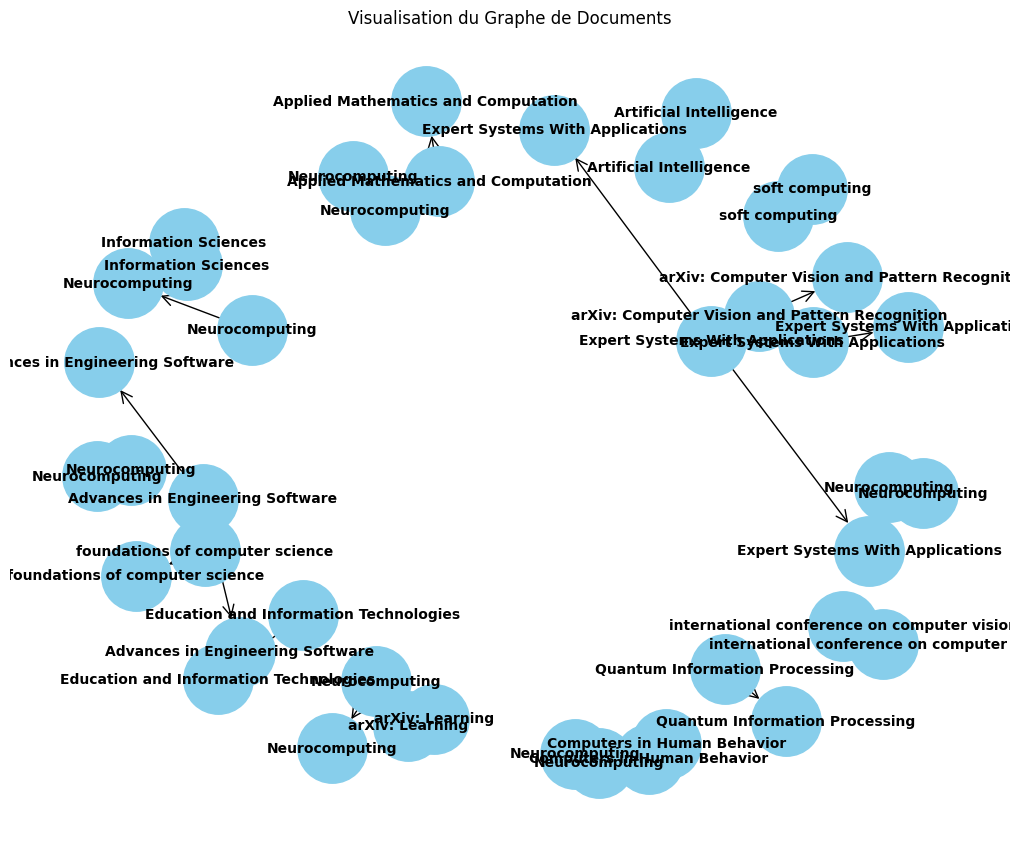

In [32]:
df2=row[:22] ##Prendre un sous ensemble
G = nx.DiGraph()

for idx, row in df2.iterrows():
    G.add_node(row['target'], label=row['Label_target'])
    G.add_node(row['source'], label=row['Label_source'])

for idx, row in df2.iterrows():
    G.add_edge(row['target'], row['source'])

plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
        node_size=2500, font_size=10, font_weight="bold", node_color='skyblue',
        arrowstyle='->', arrowsize=20)

plt.title("Visualisation du Graphe de Documents")
plt.show()


<ipython-input-40-08ca76548b84>:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G_from_df)


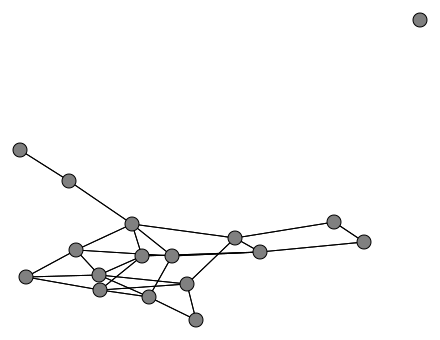

In [40]:
df2=row
G_from_df = nx.from_pandas_edgelist(df2, source='source', target='target')
adj_matrix = nx.adjacency_matrix(G_from_df)
adj_matrix_df = pd.DataFrame(adj_matrix.toarray(), index=G_from_df.nodes(), columns=G_from_df.nodes())
adjacency_matrix_np = adj_matrix.A
#Visualisation de graphe:

index = np.where(np.sum(adjacency_matrix_np,axis=0))[0]

adj_matrix = adjacency_matrix_np[index,]
adjc = adj_matrix[:,index]
adjc = csr_matrix(adjc)
img = svg_graph(adjc)
SVG(img)

###**remarque : **Il est observable que les documents citant l'un l'autre ont souvent tendance à provenir de la même conférence.

##Visualisation du graphe en entier :

In [47]:
df2=cit
G_from_df = nx.from_pandas_edgelist(df2, source='source', target='target')
adj_matrix = nx.adjacency_matrix(G_from_df)
adj_matrix_df = pd.DataFrame(adj_matrix.toarray(), index=G_from_df.nodes(), columns=G_from_df.nodes())
adjacency_matrix_np = adj_matrix.A
adjacency_matrix_np


<ipython-input-47-710c1734cadf>:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G_from_df)


array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

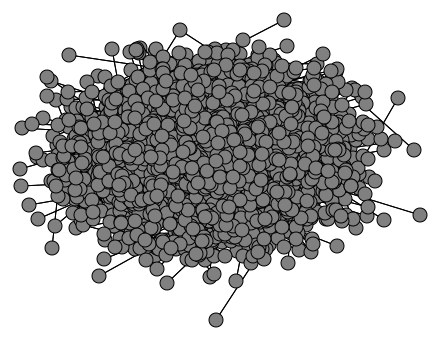

In [48]:
#Visualisation de graphe:

index = np.where(np.sum(adjacency_matrix_np,axis=0))[0]

adj_matrix = adjacency_matrix_np[index,]
adjc = adj_matrix[:,index]
adjc = csr_matrix(adjc)
img = svg_graph(adjc)
SVG(img)

In [ ]:
# On transforme la matrice en graphe
G=nx.from_numpy_array(adjacency_matrix_np)
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 1}), (0, 2630, {'weight': 1}), (0, 3947, {'weight': 1}), (0, 4313, {'weight': 1}), (2, 3, {'weight': 1}), (4, 5, {'weight': 1}), (6, 7, {'weight': 1}), (6, 171, {'weight': 1}), (6, 253, {'weight': 1}), (6, 273, {'weight': 1}), (6, 521, {'weight': 1}), (6, 800, {'weight': 1}), (6, 801, {'weight': 1}), (6, 1075, {'weight': 1}), (6, 1225, {'weight': 1}), (6, 1328, {'weight': 1}), (6, 1404, {'weight': 1}), (6, 1420, {'weight': 1}), (6, 1563, {'weight': 1}), (6, 1834, {'weight': 1}), (6, 2857, {'weight': 1}), (6, 3220, {'weight': 1}), (6, 3223, {'weight': 1}), (6, 3269, {'weight': 1}), (6, 3311, {'weight': 1}), (6, 3324, {'weight': 1}), (6, 3508, {'weight': 1}), (6, 3598, {'weight': 1}), (6, 3645, {'weight': 1}), (6, 3720, {'weight': 1}), (6, 3723, {'weight': 1}), (6, 3762, {'weight': 1}), (6, 3822, {'weight': 1}), (6, 3896, {'weight': 1}), (6, 3913, {'weight': 1}), (6, 3960, {'weight': 1}), (6, 4165, {'weight': 1}), (6, 4238, {'weight': 1}), (6, 4273, {'weig

## Quelques Statitique sur le Graphe

###Degrés :

In [ ]:
# Calcul des degrés du graphe
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = nx.degree_histogram(G)
print(np.unique(degree_sequence))
print("--------------------")
print(degree_count)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25
 27 29 31 40 41 45 48 52 66]
--------------------
[0, 1878, 58, 22, 8, 12, 8, 7, 4, 8, 9, 9, 7, 3, 5, 3, 7, 4, 5, 3, 5, 5, 4, 3, 0, 2, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###Composantes connexes :

In [ ]:
connected_components = list(nx.connected_components(G))
print(f"nbr de composantes connexes : {len(connected_components)}")
for i, component in enumerate(connected_components, start=1):
    print(f"composante {i}: {component}")

Nombre de composantes connexes : 131
Composante 1: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
Composante 2: {12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}
Composante 3: {25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43}
Composante 4: {44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59}
Composante 5: {1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 531, 533, 534, 535, 536, 537, 529, 530, 532, 525, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 523, 524, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 527, 528, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821,

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### les deux plus grande composante connexes:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


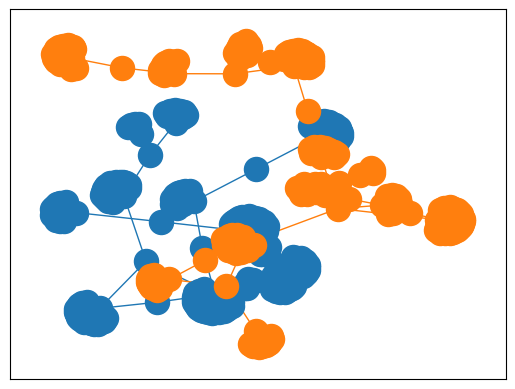

In [ ]:
GG = nx.Graph()

comp = sorted(connected_components, key=len, reverse=True)
comp = comp[:2]
colors = [f"C{i}" for i in range(len(connected_components))]
for component in comp:
    for node in component:
        GG.add_node(node)
        for neighbor in G[node]:
            if neighbor in component:
                GG.add_edge(node, neighbor)

pos = nx.spring_layout(GG)

for i, component in enumerate(comp):
    nx.draw_networkx_nodes(GG, pos, nodelist=component, node_color=f"C{i}")
    nx.draw_networkx_edges(GG, pos, edgelist=[(u, v) for u, v in GG.edges() if u in component and v in component], edge_color=f"C{i}")

plt.show()

###La densité:

In [ ]:
# Calcul densité
density = nx.density(G)
density

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0009148343664691925

In [ ]:
# Coefficients de clustering
clustering_coefficients = nx.clustering(G)
coeff_non_nul = {node: coeff for node, coeff in clustering_coefficients.items() if coeff > 0}
coeff_non_nul

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{104: 0.01818181818181818,
 110: 1.0,
 454: 0.017948717948717947,
 457: 1.0,
 460: 1.0,
 462: 1.0,
 464: 0.01717171717171717,
 466: 0.3333333333333333,
 468: 1.0,
 470: 1.0,
 472: 1.0,
 473: 1.0,
 475: 0.3333333333333333,
 477: 0.6666666666666666,
 478: 1.0,
 485: 1.0,
 490: 1.0,
 493: 0.6666666666666666,
 680: 1.0,
 968: 0.003658536585365854,
 1363: 0.006535947712418301}

# Fonction 3 : Moteur de recherche

## Using Tf_IDF encoding

In [ ]:
# TF-IDF vecto documentts
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_document['texte'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def search_tfidf(query, top_n=10):
    query_vec = tfidf_vectorizer.transform([query])
    similarity = cosine_similarity(query_vec, tfidf_matrix)
    top_n_indices = similarity[0].argsort()[-top_n:][::-1]
    return df_document.iloc[top_n_indices]['ID']

query = "Artificial intelligence and deep learning"
print(search_tfidf(query))

122269    77c575cd-094b-49d9-8e71-d915b66d2f13
97762     b4e86470-1668-425a-a017-97388d070f10
32256     dcbdee8a-7218-40ff-8f08-ec1fa98f7654
67501     280a717e-518b-4d75-996e-456994c1d449
13324     0c611553-8e1e-491a-961a-c4fedb264081
49998     2054d65d-016d-434d-b500-a9b66b6c3fe0
184773    5f3e7767-5271-47e9-9107-4147e1d5cf3f
164058    a1cc4e80-1bbb-4bfa-8791-68fd4c98aee7
179781    32e4132b-2ae7-49ca-b883-56eeb435789a
4415      11a2c8dd-ce69-450d-86e1-ec4c23950952
Name: ID, dtype: object


## Using Bert

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

def encode_texts_with_distilbert(texts, batch_size=256):
    model.eval()
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=512).to(device)
        with torch.no_grad():
            output = model(**encoded_input)
        batch_embeddings = output.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings.cpu())
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings.numpy()

### Creation Embdeddings

In [ ]:
embeddings = encode_texts_with_distilbert(df_document['texte'].tolist())

In [ ]:
#np.savetxt('/content/gdrive/My Drive/data_MALIA/documents_embeddings.csv',embeddings,delimiter=',')

### Utilisation BERT

In [ ]:
embeddings = pd.read_csv('/content/gdrive/My Drive/data_MALIA/documents_embeddings.csv',delimiter=',',header=None)

In [ ]:
def search_bert(query, top_n=10):
    query_vec = encode_texts_with_distilbert([query])
    similarity = cosine_similarity(query_vec, embeddings)
    top_n_indices = similarity[0].argsort()[-top_n:][::-1]
    return df_document.iloc[top_n_indices]['ID']

query = "Artificial intelligence and deep learning"
print(search_bert(query))

99574     bd234a55-acd9-49ad-9e1f-83df54a9169b
14790     1cc573b3-84fb-4e92-b23e-1ef73d3331a7
115693    180412ba-65ab-45fb-9502-10d9bd2a50ea
46081     3a7e6114-0290-4b1b-9466-6c8a48c0e6ad
141745    27018ae4-f29b-408d-a971-c42e9660f838
146393    ad27dace-d76d-401a-b91a-933e2d274664
57442     dc646350-2c4c-4dde-a44f-e217d961abf4
168129    820caaa9-01e2-4965-a34c-0012c6cc2c35
58581     f80c5ded-0146-45ea-b768-2058d942f06b
136752    740daeaf-8165-4e42-b07a-7817ed2359bf
Name: ID, dtype: object


# Fonction 4 : Ajout de clustering

###1. Clustering basé sur le contenu textuel


**Idée générale :** Utiliser les informations textuelles (résumés ou textes complets) des documents pour regrouper ceux qui traitent de sujets similaires.

En premier temps nous allons supprimer les valeurs manquantes dans les venue.
Nous allons prendre que les documents qui sont associés aux 5 labels (venue) les plus fréquents

In [11]:
df = df.dropna(subset=['venue'])

label_counts = Counter(df['venue'])

column = [label for label, count in label_counts.most_common(5)]

data= df[df['venue'].isin(column)]

data['venue'].value_counts()

international conference on communications               535
Sensors                                                  366
international geoscience and remote sensing symposium    363
conference on decision and control                       352
Applied Mathematics and Computation                      339
Name: venue, dtype: int64

Nous allons encoder les deux colonnes texte et venue avec Tf-IDF :

In [12]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

tfidf_matrix = tfidf_vectorizer.fit_transform(data['texte'])
tfidf_matrix.shape

(1955, 1000)

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(data['venue'])

encoded_labels, label_encoder.classes_

(array([2, 3, 3, ..., 3, 4, 3]),
 array(['Applied Mathematics and Computation', 'Sensors',
        'conference on decision and control',
        'international conference on communications',
        'international geoscience and remote sensing symposium'],
       dtype=object))

####Kmeans :

In [35]:

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(tfidf_matrix)

cluster_labels = kmeans.labels_
clusters = np.unique(cluster_labels, return_counts=True)

clusters


(array([0, 1, 2, 3, 4], dtype=int32), array([241, 508, 269, 410, 527]))

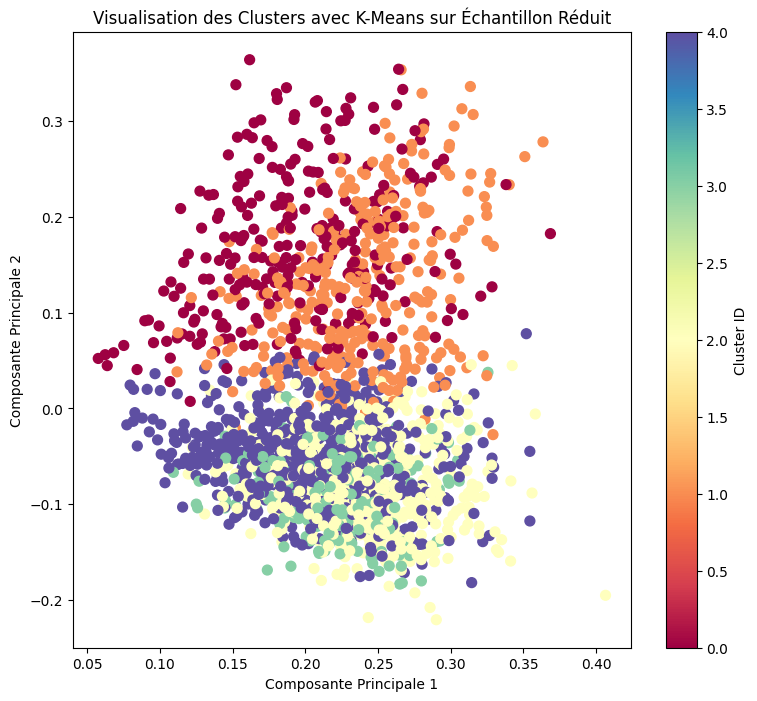

In [ ]:
plt.figure(figsize=(9, 8))

from sklearn.decomposition import TruncatedSVD

if X.shape[1] > 2:
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_red = svd.fit_transform(tfidf_matrix)
else:
    X_red = tfidf_matrix

plt.scatter(X_red[:, 0], X_red[:, 1], c=cluster_labels, cmap='Spectral', s=50)
plt.title('Visualisation des Clusters avec K-Means sur Échantillon Réduit')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.colorbar(label='Cluster ID')
plt.show()

Cette répartition montre comment les documents sont organisés en groupes basés sur leur similarité de contenu, selon la représentation vectorielle Bert et l'algorithme K-Means.

###Analyse de Correspondance entre Clusters et Labels Catégoriels via ARI et AMI:



Dans cette section, nous avons entrepris une analyse comparative entre les labels catégoriels fournis ('venue') et les clusters générés par l'algorithme K-Means appliqué sur des données textuelles vectorisées via TF-IDF. Le but était de mesurer qualitativement et quantitativement dans quelle mesure les groupements naturels découverts par K-Means correspondent aux classifications prédéfinies

In [ ]:
encoded_labels = label_encoder.transform(data['venue'])

ari_score = adjusted_rand_score(encoded_labels, cluster_labels)
ami_score = adjusted_mutual_info_score(encoded_labels, cluster_labels, average_method='arithmetic')

ari_score, ami_score

(0.48030853413471936, 0.5174582996117099)

###Réduction de dimension avec UMAP suivie de HDBSCAN


In [36]:

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(tfidf_matrix)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True,alpha=0.2)
clusterer.fit(embedding)

hdbscan_labels = clusterer.labels_


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


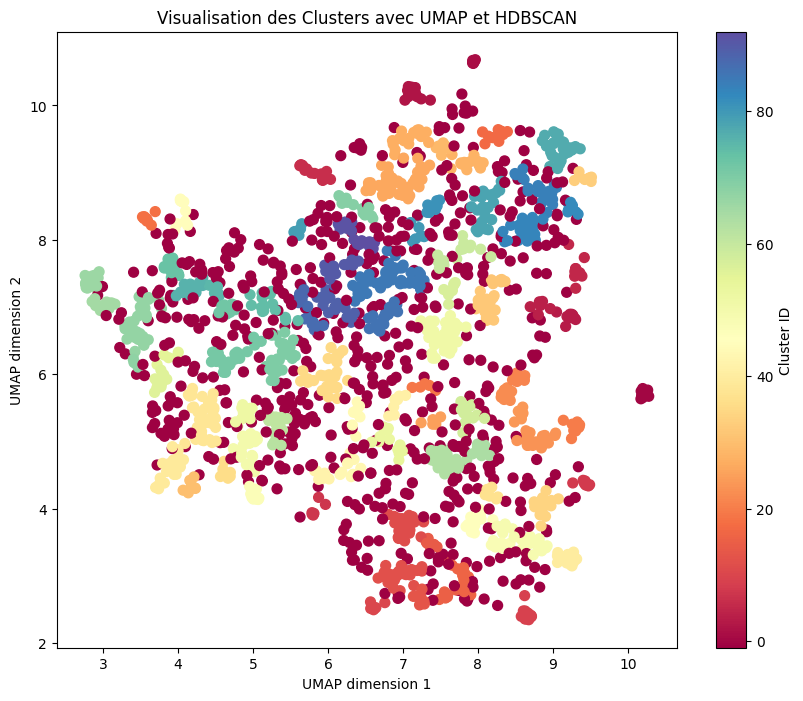

In [37]:
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusterer.labels_, cmap='Spectral', s=50)
plt.title('Visualisation des Clusters avec UMAP et HDBSCAN')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.colorbar(label='Cluster ID')
plt.show()

In [38]:
encoded_labels = label_encoder.transform(data['venue'])

ari_score = adjusted_rand_score(encoded_labels, clusterer.labels_)
ami_score = adjusted_mutual_info_score(encoded_labels, clusterer.labels_, average_method='arithmetic')

ari_score, ami_score

(0.022772934407822867, 0.23928697315158834)

Hdbscan a renvoyé des résultats moins satisfaisants que K-Means en raison de sa sensibilité aux paramètres comme la taille minimale des clusters et la difficulté à ajuster la distance minimale entre eux, ainsi que de son attribution de certains points à du bruit ou à des outliers, ce qui peut sous-représenter ou ignorer des groupes réels dans les données, contrairement à K-Means.








###2. Clustering basé sur le graphe :


####Clustring Spectral :

In [50]:
import numpy as np
from sklearn.cluster import SpectralClustering
from scipy.sparse import csr_matrix

adjacence_np = adjc.toarray()

n_clusters = 5
clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')
labels = clustering.fit_predict(adjacence_np)



/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


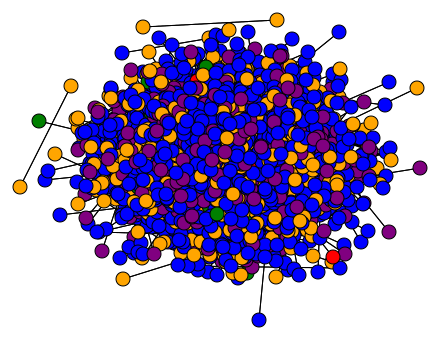

In [51]:
image = svg_graph(adjc, labels=labels)
SVG(image)

###Représentation vectorielle de noeuds:

In [55]:
from node2vec import Node2Vec

G = nx.Graph(adjc)
rpt = Node2Vec(G, dimensions=128, walk_length=40, num_walks=100, workers=2)
NODE = rpt.fit()
NODE.wv.vectors

Computing transition probabilities:   0%|          | 0/5029 [00:00<?, ?it/s]

array([[ 0.40463746,  0.50816274,  0.30772105, ..., -0.30549467,
        -0.0529607 ,  0.19296584],
       [ 0.32257193,  0.773699  ,  0.84380174, ..., -0.63675463,
        -0.28406218,  0.14308143],
       [ 0.5263358 ,  0.27631843,  0.06389666, ...,  0.39054415,
         0.34489143,  0.24870497],
       ...,
       [ 0.39864302,  0.53568995,  0.3991361 , ..., -0.2293986 ,
         0.08253958,  0.25223014],
       [ 0.339721  ,  0.61710036,  0.39630258, ..., -0.26636297,
         0.03653931,  0.23933946],
       [ 0.5393925 ,  0.8814077 ,  0.05993641, ..., -0.1150352 ,
        -0.22689529, -0.13378274]], dtype=float32)

Il semble que le clustring spectral a du mal a detecter les clusters.

# Fonction 5 : Classification supervis´ee

In [ ]:
print(embeddings.shape)
print(df_document.shape)

(188143, 768)
(188143, 5)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Genreration des labels grace aux LLMs: chatgpt**

**PROMPT**: i have a list of article titles in a csv, i want to get generate a class label for each title, first give me a list of possible lables, given that the the papers are in computer science, give me a list of categories a can use as paper labels like artificial intelligence, cloud computing...

**PROMPT**:  you will assign each title the corresepodant category for example a title in which talk about an ai technique should be assigned to artificial intelligence and so on. the output should be in a csv i can download,

In [ ]:
labels = pd.read_csv('/content/gdrive/My Drive/data_MALIA/categorized_titles.csv')['category']
df_document['category'] = labels

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_document

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ID  \
0       04b38d22-d10c-4b84-8a9d-bd610400aa4e   
1       086c091e-d905-4f1c-9385-eec41ad55723   
2       3089c330-983b-4d83-9b82-fdc7ba8b316c   
3       328ff460-ca4e-4f83-b100-0b3535b5f30a   
4       38f94267-fdf2-4c45-b930-df351b7fc6a8   
...                                      ...   
188138  afe2349c-ebcd-43d7-a450-129e6ba55a68   
188139  b8c8085e-6373-4ffe-a647-deac4f4e6037   
188140  c505c089-89f3-4b9a-b6df-4be7e22f5c95   
188141  ccae04f8-a75b-4c6b-87f6-47c042c97db2   
188142  d44c1025-241d-49fd-8710-55259d7c2cd3   

                                                    title  \
0       Monetization as a Motivator for the Freemium E...   
1       Towards intelligent distributed computing : ce...   
2       Changes in Urban Area Discovered by Analysis o...   
3       A Survey of Social Web Mining Applications for...   
4             Quantized Control and Data-Rate Constraints   
...                                                   ...   
188138   The Composition Theorem for Differential Privacy   
188139               Redistribution by Means of Lotteries   
188140  Association schemes based on the subspaces of ...   
188141         Editing to a Planar Graph of Given Degrees   
188142  h-graphs: A new representation for tree decomp...   

                                                 abstract  \
0       The paper describes user behavior as a result ...   
1       Distributed computing systems are of huge impo...   
2       A period of almost 150 years (since the middle...   
3       The final publication is available at Springer...   
4       This article briefly describes the topic of qu...   
...                                                   ...   
188138  Sequential querying of differentially private ...   
188139  A government designs transfers to agents in th...   
188140  In this paper, we provide a construction of as...   
188141  We consider the following graph modification p...   
188142  Abstract   In geometric constraint solving, 2D...   

                                               venue  \
0                       arXiv: Computers and Society   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
...                                              ...   
188138  international conference on machine learning   
188139                                           NaN   
188140           Linear Algebra and its Applications   
188141          computer science symposium in russia   
188142                         Computer-aided Design   

                                                    texte  \
0       the paper describes user behavior result intro...   
1       distributed computing systems huge importance ...   
2       a period almost years since middle th century ...   
3       the final publication available springer via h...   
4       this article briefly describes topic quan tize...   
...                                                   ...   
188138  sequential querying differentially private mec...   
188139  a government designs transfers agents absence ...   
188140  in paper provide construction association sche...   
188141  we consider following graph modification probl...   
188142  abstract in geometric constraint solving d wel...   

                                category  
0              E-Commerce and E-Business  
1                                  Other  
2       Urban Computing and Smart Cities  
3        Social Web and Web Technologies  
4           Control Systems and Robotics  
...                                  ...  
188138                             Other  
188139                             Other  
188140                             Other  
188141                             Other  
188142                             Other  

[188143 rows x 6 columns]

In [ ]:
df_document['category'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


category
Other                                              174752
Algorithm Design and Analysis                        8409
Database Systems                                      965
Cloud Computing                                       604
Machine Learning (ML)                                 576
Networking and Communications                         533
Internet of Things (IoT)                              466
Deep Learning                                         284
Software Engineering                                  235
Robotics                                              215
Virtual Reality (VR) and Augmented Reality (AR)       177
Graphics and Visualization                            125
E-Commerce and E-Business                             109
Distributed Systems                                    89
Computer Vision                                        87
Artificial Intelligence (AI)                           78
Ethical and Social Aspects of Computing                73
Cyber

On elimine les classes majoritaire sans information particuliere tel que Others
et les classes minoritaire

In [ ]:
classification_data=df_document[df_document['category'].isin([
    'Cloud Computing',
    'Machine Learning (ML)',
    'Networking and Communications',
    'Internet of Things (IoT)',
    'Deep Learning ',
    'Software Engineering',
    'Robotics'])]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Using document embedding on the abstract and title

In [ ]:
data = embeddings.loc[classification_data.index]
X

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0         1         2         3         4         5         6    \
51     -0.085991  0.280492  0.350724 -0.029054 -0.166290  0.050377  0.064582   
184    -0.098945  0.067964  0.299154  0.160454  0.094774  0.088686  0.017584   
226    -0.090944  0.123931  0.023389 -0.059823 -0.083785  0.074272  0.362633   
331    -0.120643  0.180082  0.364879 -0.076322  0.102884  0.014521  0.207037   
406    -0.116011  0.176456  0.401389  0.000868  0.258158  0.002486  0.115308   
...          ...       ...       ...       ...       ...       ...       ...   
187328 -0.369777  0.163791  0.014516 -0.002533 -0.063711  0.085205  0.243369   
187417 -0.043930 -0.000231  0.416920  0.101809  0.127942  0.039306  0.015989   
187476 -0.272774  0.177486  0.371978 -0.000334  0.144157  0.020634  0.121424   
187650 -0.137030  0.166045  0.345528 -0.026647  0.178487  0.007075  0.277465   
188050 -0.062863  0.111072  0.207476 -0.134772 -0.103787  0.266983  0.344250   

             7         8         9    ...       758       759       760  \
51     -0.096902  0.020872 -0.128305  ... -0.027232 -0.068222  0.059481   
184     0.033998 -0.041098 -0.303371  ... -0.092151 -0.070302 -0.024344   
226    -0.120202  0.334686 -0.228636  ...  0.012571  0.015411 -0.014132   
331     0.019036  0.024149 -0.206902  ... -0.213385 -0.171445  0.298875   
406    -0.055587  0.185927 -0.347841  ... -0.228945 -0.133791  0.312115   
...          ...       ...       ...  ...       ...       ...       ...   
187328 -0.014844  0.045702 -0.217946  ... -0.112712  0.030042 -0.115939   
187417 -0.035321  0.060049 -0.167143  ... -0.122309 -0.137574  0.012107   
187476 -0.076658  0.046887 -0.209001  ... -0.098062 -0.025392  0.041393   
187650 -0.061352  0.139464 -0.138782  ... -0.099208 -0.063940  0.055469   
188050 -0.027797  0.238412 -0.174918  ... -0.323147 -0.091737  0.098170   

             761       762       763       764       765       766       767  
51     -0.027350 -0.227225 -0.240014 -0.193519 -0.367558  0.169313 -0.222958  
184    -0.011442 -0.200726  0.020775  0.065379 -0.297485 -0.076232 -0.050030  
226     0.118118 -0.276048 -0.126876 -0.134222 -0.286241 -0.021851 -0.216602  
331     0.062044 -0.161280 -0.448099 -0.221871 -0.307503 -0.006065 -0.254732  
406    -0.088039 -0.193752 -0.172074  0.004169 -0.314136 -0.142117 -0.160760  
...          ...       ...       ...       ...       ...       ...       ...  
187328  0.123349 -0.260592 -0.227313 -0.083242 -0.412461 -0.009897 -0.212711  
187417  0.023436 -0.303858 -0.067011 -0.153330 -0.152962 -0.063582 -0.237475  
187476 -0.021051 -0.093616 -0.053895 -0.116001 -0.217133 -0.174281 -0.035096  
187650 -0.004442 -0.202847 -0.237302 -0.113193 -0.251295 -0.107422 -0.252074  
188050  0.074586 -0.171053 -0.282449 -0.004108 -0.400311 -0.180759  0.033087  

[2629 rows x 768 columns]

In [ ]:
y = classification_data['category']

In [ ]:
!pip install lazypredict

In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)


In [ ]:
models

Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RidgeClassifierCV                  0.91               0.91    None      0.91   
LinearDiscriminantAnalysis         0.89               0.89    None      0.89   
CalibratedClassifierCV             0.89               0.88    None      0.89   
RidgeClassifier                    0.89               0.88    None      0.89   
LogisticRegression                 0.87               0.88    None      0.87   
PassiveAggressiveClassifier        0.88               0.88    None      0.88   
LinearSVC                          0.86               0.86    None      0.86   
SGDClassifier                      0.86               0.85    None      0.86   
Perceptron                         0.86               0.85    None      0.86   
SVC                                0.86               0.84    None      0.86   
LGBMClassifier                     0.82               0.80    None      0.82   
NuSVC                              0.82               0.78    None      0.81   
ExtraTreesClassifier               0.77               0.74    None      0.77   
RandomForestClassifier             0.77               0.74    None      0.76   
GaussianNB                         0.71               0.74    None      0.71   
NearestCentroid                    0.70               0.73    None      0.70   
BernoulliNB                        0.68               0.71    None      0.68   
KNeighborsClassifier               0.72               0.71    None      0.72   
BaggingClassifier                  0.62               0.59    None      0.61   
AdaBoostClassifier                 0.54               0.56    None      0.53   
DecisionTreeClassifier             0.48               0.46    None      0.48   
ExtraTreeClassifier                0.40               0.38    None      0.40   
QuadraticDiscriminantAnalysis      0.20               0.19    None      0.20   
DummyClassifier                    0.25               0.17    None      0.10   
LabelSpreading                     0.25               0.17    None      0.10   
LabelPropagation                   0.25               0.17    None      0.10   

                               Time Taken  
Model                                      
RidgeClassifierCV                    0.87  
LinearDiscriminantAnalysis           1.32  
CalibratedClassifierCV              28.28  
RidgeClassifier                      0.21  
LogisticRegression                   0.85  
PassiveAggressiveClassifier          1.51  
LinearSVC                            5.76  
SGDClassifier                        1.88  
Perceptron                           0.62  
SVC                                  1.82  
LGBMClassifier                      65.70  
NuSVC                                2.75  
ExtraTreesClassifier                 1.08  
RandomForestClassifier               6.83  
GaussianNB                           0.11  
NearestCentroid                      0.12  
BernoulliNB                          0.27  
KNeighborsClassifier                 0.19  
BaggingClassifier                   27.30  
AdaBoostClassifier                  22.67  
DecisionTreeClassifier               1.95  
ExtraTreeClassifier                  0.10  
QuadraticDiscriminantAnalysis        0.76  
DummyClassifier                      0.07  
LabelSpreading                       0.45  
LabelPropagation                     0.38

from matplotlib import pyplot as plt
models['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
models['Balanced Accuracy'].plot(kind='hist', bins=20, title='Balanced Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
models['F1 Score'].plot(kind='hist', bins=20, title='F1 Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
models['Time Taken'].plot(kind='hist', bins=20, title='Time Taken')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
models.plot(kind='scatter', x='Accuracy', y='Balanced Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
models.plot(kind='scatter', x='Balanced Accuracy', y='F1 Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
models.plot(kind='scatter', x='F1 Score', y='Time Taken', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time Taken']
  ys = series['Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = models.sort_values('Time Taken', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time Taken')
_ = plt.ylabel('Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time Taken']
  ys = series['Balanced Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = models.sort_values('Time Taken', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time Taken')
_ = plt.ylabel('Balanced Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time Taken']
  ys = series['F1 Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = models.sort_values('Time Taken', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time Taken')
_ = plt.ylabel('F1 Score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Time Taken']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Time Taken'}, axis=1)
              .sort_values('Time Taken', ascending=True))
  xs = counted['Time Taken']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = models.sort_values('Time Taken', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time Taken')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
models['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
models['Balanced Accuracy'].plot(kind='line', figsize=(8, 4), title='Balanced Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
models['F1 Score'].plot(kind='line', figsize=(8, 4), title='F1 Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
models['Time Taken'].plot(kind='line', figsize=(8, 4), title='Time Taken')
plt.gca().spines[['top', 'right']].set_visible(False)

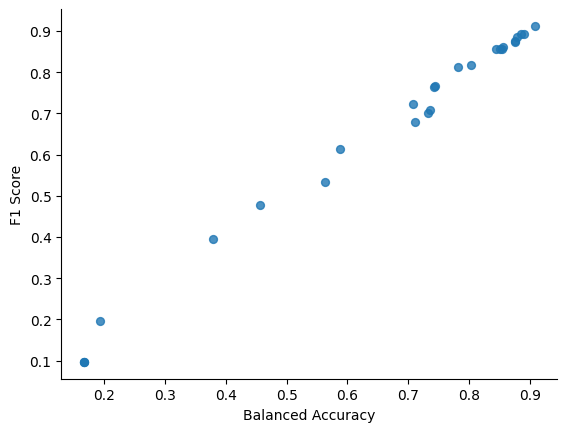

In [ ]:
from matplotlib import pyplot as plt
models.plot(kind='scatter', x='Balanced Accuracy', y='F1 Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

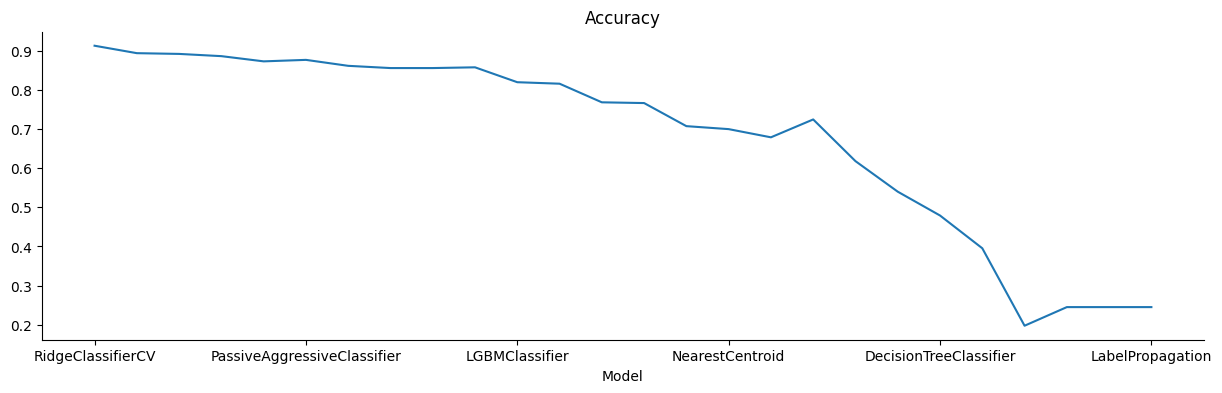

In [ ]:
from matplotlib import pyplot as plt
models['Accuracy'].plot(kind='line', figsize=(15, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

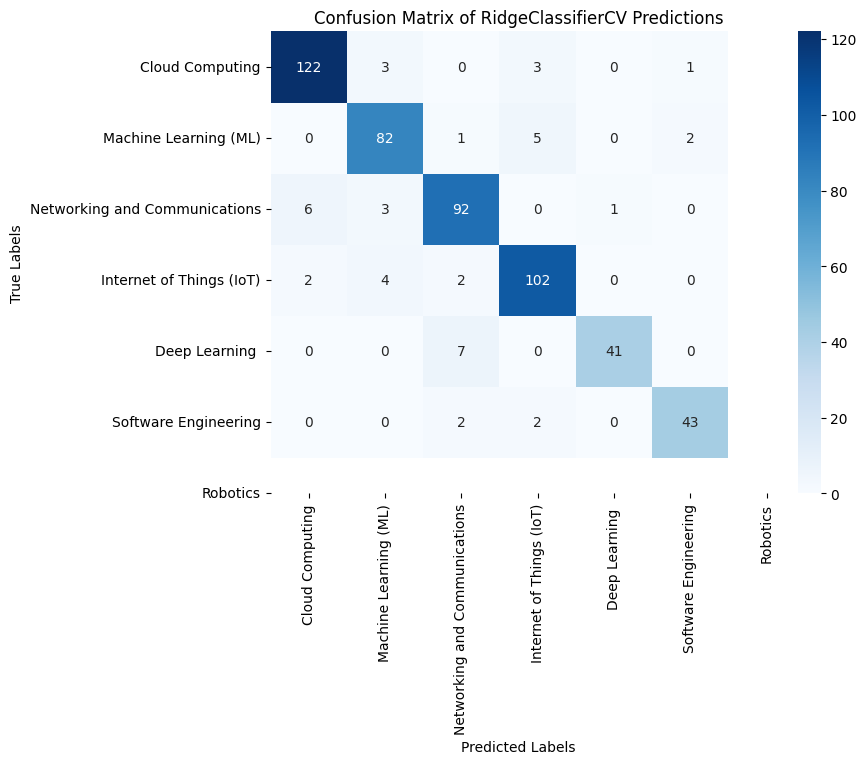

In [ ]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import confusion_matrix
import seaborn as sns


ridge_classifier = RidgeClassifierCV()
ridge_classifier.fit(X_train, y_train)
y_pred = ridge_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
l = [
    'Cloud Computing',
    'Machine Learning (ML)',
    'Networking and Communications',
    'Internet of Things (IoT)',
    'Deep Learning ',
    'Software Engineering',
    'Robotics']
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=l, yticklabels=l)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of RidgeClassifierCV Predictions')
plt.show()

## Using Graph structure

In [ ]:
df2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


target  \
0     04b38d22-d10c-4b84-8a9d-bd610400aa4e   
1     04b38d22-d10c-4b84-8a9d-bd610400aa4e   
2     04b38d22-d10c-4b84-8a9d-bd610400aa4e   
3     04b38d22-d10c-4b84-8a9d-bd610400aa4e   
4     04b38d22-d10c-4b84-8a9d-bd610400aa4e   
...                                    ...   
1995  a3688107-5c83-45fe-bb98-6c838824f518   
1996  0cbb19c6-0956-4066-b573-9b1dfcb7d6a5   
1997  0cbb19c6-0956-4066-b573-9b1dfcb7d6a5   
1998  0cbb19c6-0956-4066-b573-9b1dfcb7d6a5   
1999  0cbb19c6-0956-4066-b573-9b1dfcb7d6a5   

                                    source  
0     20bd450e-1e64-4350-8b4e-16c25ece050f  
1     22ab2de7-1e10-4b34-bd95-b40b044412f4  
2     43a92b7b-b065-43b3-921a-fbb90b7ec63f  
3     5432e816-4fcc-4ca2-8a22-66ab19e7d8bd  
4     77a3f5e6-6a65-4b94-96a3-7674234f9c07  
...                                    ...  
1995  f7facac6-c5b4-4ea4-aaad-fa2b6777c284  
1996  2dec6830-0684-4569-a52f-59cfae86a88a  
1997  36bc84b0-04f2-448f-bfad-028ef54e77c6  
1998  89d1c0f2-85c5-43ad-9f25-667a1ed1d85f  
1999  b28a804c-bb95-423e-8991-13e64e27306f  

[2000 rows x 2 columns]

In [ ]:
all_doc_ids = pd.unique(df2[['target', 'source']].values.ravel('K'))
doc_id_to_index = {doc_id: index for index, doc_id in enumerate(all_doc_ids)}
adj_matrix = np.zeros((len(all_doc_ids), len(all_doc_ids)))
for _, row in df2.iterrows():
    source_index = doc_id_to_index[row['source']]
    target_index = doc_id_to_index[row['target']]
    adj_matrix[target_index, source_index] = 1
adj_matrix.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2091, 2091)

In [ ]:
y=[]
index_to_doc_id = {index: doc_id for doc_id, index in doc_id_to_index.items()}
for row_index in range(adj_matrix.shape[0]):
    doc_id = index_to_doc_id[row_index]
    document_row = df_document.loc[df_document['ID'] == doc_id]['category']
    y.append(document_row)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score

y = []
for row_index in range(adj_matrix.shape[0]):
    doc_id = index_to_doc_id[row_index]
    document_row = df_document.loc[df_document['ID'] == doc_id, 'category'].values
    if len(document_row) > 0:
        y.append(document_row[0])
    else:
        y.append(None)

X, y = zip(*[(adj_matrix[i], category) for i, category in enumerate(y) if category is not None])
y = np.array(y)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100])
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy: 0.9069767441860465


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


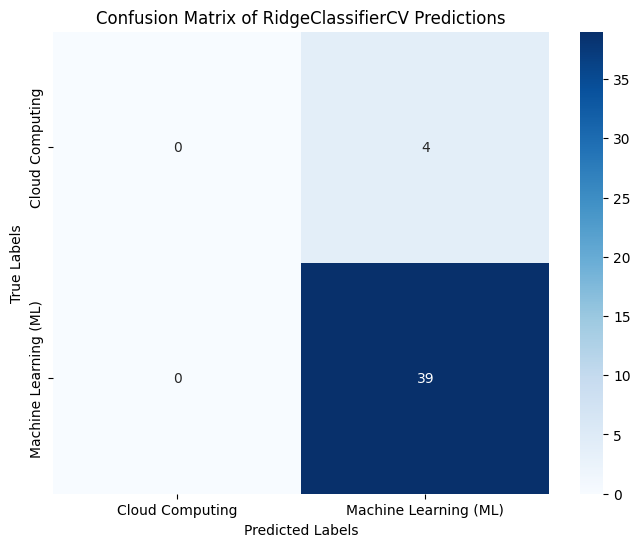

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
l = [
    'Cloud Computing',
    'Machine Learning (ML)',
    ]
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=l, yticklabels=l)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of RidgeClassifierCV Predictions')
plt.show()
# Even though accuracy is high, poor classification for cloud computing